In [56]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
matplotlib.rcParams['text.usetex'] = True
import pandas as pd
import numpy as np
import random
import os
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
import time
import networkx as nx
from sklearn.cluster import KMeans

plt.rcParams['axes.unicode_minus']=False

path = 'result/model_comparison'
if not os.path.exists(path):
    os.makedirs(path)

In [192]:
def examine(Y0, h=0.1):
    def daoshu(x, h):
        return x[2:-2], (x[:-4] - 8* x[1:-3] + 8* x[3:-1] - x[4:])/(12*h)
    
    n_delay = int(17/h)
    Y1, Y1d = daoshu(Y0, h)
    plt.figure(figsize=(20,3))
    plt.plot(Y1)
    plt.figure(figsize=(20,3))
    plt.plot(Y1d)
    Y_delay = Y1[:-n_delay]
    Y = Y1[n_delay:]
    Yd = Y1d[n_delay:]
    plt.figure(figsize=(4,4))
    plt.plot(Y,Y_delay, 'k')
    plt.xlabel(r'$y(t)$')
    plt.ylabel(r'$y(t-\tau)$')
    plt.tight_layout()

    a=0.2;
    b=0.1;
    c=10;

    Ydd = a * Y_delay / (1+Y_delay**c) - b*Y
    plt.figure(figsize=(8,2))
    plt.plot(Ydd, 'k', label='from system equation')
    plt.plot(Yd,'r--', label='from numerical computation')
    plt.xlabel('step')
    plt.legend(loc='upper left')
    plt.title('DE = {:.3g}'.format(np.average(np.square(Ydd-Yd))))
    plt.tight_layout()
#     plt.savefig(path+'/MG-attractor-error.pdf')

#     fig, ax = plt.subplots(figsize=(4,4))
# #     ax.violinplot(np.square(Ydd-Yd),
# #                showmeans=False,
# #                showmedians=True,
# #               showextrema=False,
# #               quantiles=[[0.25,0.5,0.75]]
# #                )
#     ax.boxplot(np.square(Ydd-Yd))
# #     ax.set_yscale('log')
#     plt.show()

# examine(Y.squeeze(), h=0.1)

def multistep_batch(model, horizon):
    Preds = []
    X = X_test
    for h in tqdm(range(horizon)):
        pred = model.predict(X)
        X = np.hstack([X[:,1:],pred.reshape(-1,1)])
        err = np.average(np.square(dataY[test_start+h:test_start+num_test+h] - pred))
        Preds.append(err)  
    return Preds

(10000, 50) (10000,)


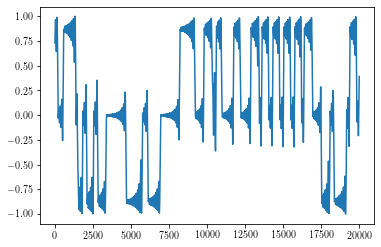

In [259]:
# system_name = 'Rabinovich Fabrikant'
system_name = 'Chua'
# system_name = 'Lorenz'
# system_name = 'Rossler'
dim = [0]
Y = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T
Y = np.atleast_2d(Y)
U0 = Y[dim].copy()
U = U0 + np.random.randn(*U0.shape)*1e-3

_ = plt.plot(U.T)

n_features = 50
dataX = np.vstack([U[:,i:-n_features+i] for i in range(n_features)]).T
dataY = U0[:,n_features:].squeeze()

num_prepare = 1000
train_start = num_prepare
num_train = 10000
val_start = num_prepare + num_train
num_val = 1000
test_start = num_prepare + num_train + num_val
num_test = 5000

X_train = dataX[train_start:train_start+num_train]
Y_train = dataY[train_start:train_start+num_train]
X_test = dataX[test_start:test_start+num_test]
Y_test = dataY[test_start:test_start+num_test]

print(X_train.shape, Y_train.shape)

# Naive

4.09614992146486


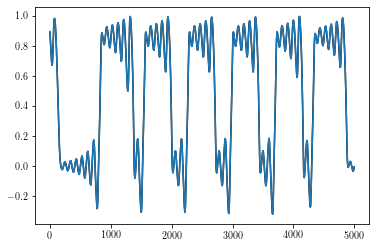

In [260]:

class Naive:
    def __init__(self):
        pass
    def fit(self, X, y):
        pass
    def predict(self, X):
        return X[:,-1]
    

naive = Naive()
naive.fit(X_train, Y_train)
Y_pred = naive.predict(X_test)
err = np.average(np.square(Y_pred-Y_test))
err = -np.log10(err)
print(err)

plt.figure()
plt.plot(Y_test, 'k')
plt.plot(Y_pred)

# LR

5.748025429696918


  0%|          | 0/30 [00:00<?, ?it/s]

5.748025429696918
3.4297819779414107
2.347873101996614
1.7743377875199136


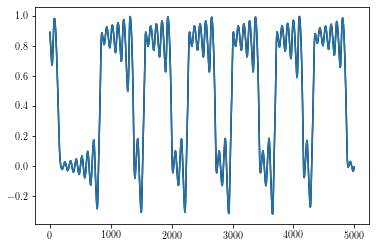

In [261]:
lr = linear_model.Ridge(alpha=1e-6)

lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)
err = np.average(np.square(Y_pred-Y_test))
err = -np.log10(err)
print(err)

plt.figure()
plt.plot(Y_test, 'k')
plt.plot(Y_pred)

errs = multistep_batch(lr, 30)
errs = -np.log10(errs)
for i in [1,10,20,30]:
    print(errs[i-1])

# KernelRidge

0.02
6.169428070404918


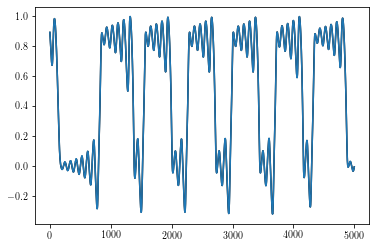

In [262]:
from sklearn.kernel_ridge import KernelRidge

for gamma in [0.02,]:
    print(gamma)
    kr = KernelRidge(kernel='rbf',gamma=gamma,alpha=1e-6)
    kr.fit(X_train, Y_train)

    Y_pred = kr.predict(X_test)
    err = np.average(np.square(Y_pred-Y_test))
    err = -np.log10(err)
    print(err)

plt.figure()
plt.plot(Y_test, 'k')
plt.plot(Y_pred)


In [263]:
errs = multistep_batch(kr, 30)
errs = -np.log10(errs)
for i in [1,10,20,30]:
    print(errs[i-1])

  0%|          | 0/30 [00:00<?, ?it/s]

6.169428070404918
4.6407402625406435
4.072216041269619
3.8859096661548422


# decision tree

In [188]:
from sklearn import tree
dt = tree.DecisionTreeRegressor()
dt.fit(X_train, Y_train)

Y_pred = dt.predict(X_test)
err = np.average(np.square(Y_pred-Y_test))
err = -np.log10(err)
print(err)

# help(tree.DecisionTreeRegressor())

4.005580775291611


# knn

In [189]:
from sklearn.neighbors import KNeighborsRegressor

best_choice = []
for n_neighbors in [i for i in range(1,10)]:
    print(n_neighbors)
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(X_train, Y_train)

    Y_pred = knn.predict(X_test)
#     plt.figure()
#     plt.plot(Y_test, 'k')
#     plt.plot(Y_pred)
    err = np.average(np.square(Y_pred-Y_test))
    err = -np.log10(err)
    print(err)
    best_choice.append((err, n_neighbors))

best_choice.sort()
print(best_choice[-1])

1
3.022205364136772
2
3.10001537228015
3
3.1648636379344808
4
3.1633518545620993
5
3.15496308293983
6
3.1487406756832885
7
3.1233770206404623
8
3.1038119787519456
9
3.0857536751300816
(3.1648636379344808, 3)


# multi

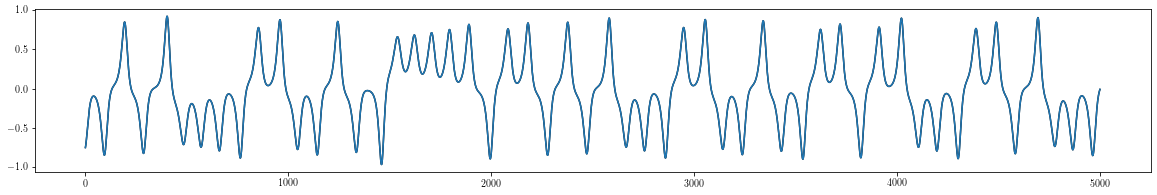

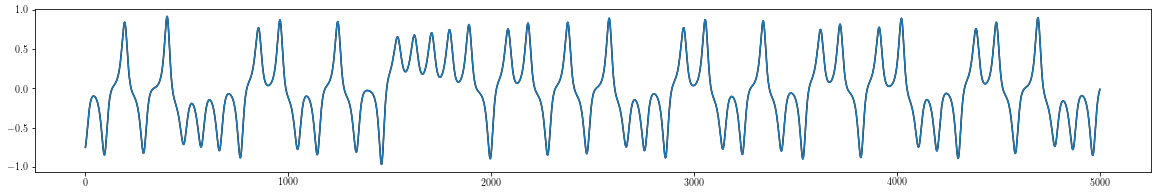

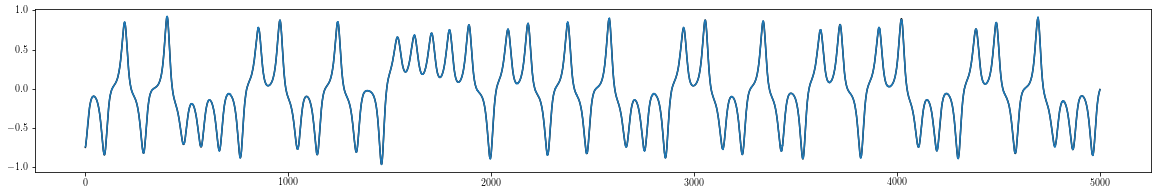

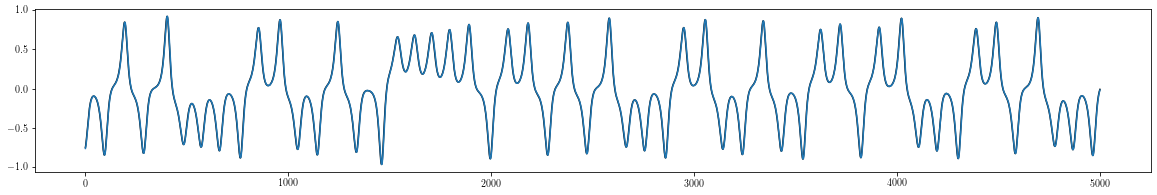

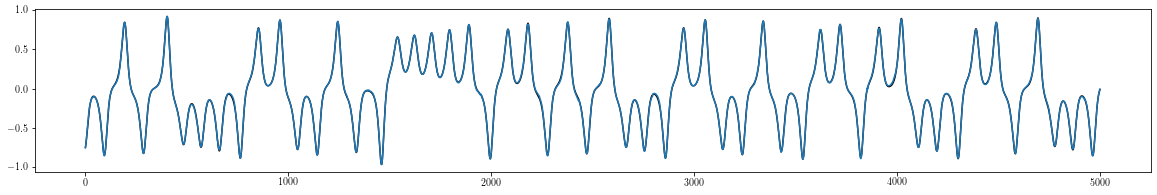

In [67]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model

class Naive:
    def __init__(self):
        pass
    def fit(self, X, y):
        pass
    def predict(self, X):
        return X[:,-1]

knn = KNeighborsRegressor(n_neighbors=1)
dtree = tree.DecisionTreeRegressor()
kr = KernelRidge(kernel='rbf',gamma=0.1,alpha=1e-6)
naive = Naive()
lr = linear_model.Ridge(alpha=1e-6)

models = [kr, lr, dtree,naive, knn]
err1step = []
err100step = []
de = []
for model in models:
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    plt.figure(figsize=(20,3))
    plt.plot(Y_test, 'k')
    plt.plot(Y_pred)
    plt.show()
    err = np.average(np.square(Y_pred-Y_test))
    err1step.append(err)

esn_err = np.loadtxt('result/Mackey-Glass/multi-pred result.csv', dtype="float",delimiter=',')
err1step = [esn_err[0]] + err1step

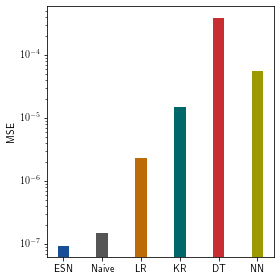

In [69]:

model_names = ['ESN'] + [ 'Naive','LR','KR', 'DT', 'NN']
colors = ['#194f97', '#555555', '#bd6b08', '#00686b', '#c82d31',   '#9c9800','#625ba1','#898989', '#007f54', '#a195c5', '#103667', '#f19272']
plt.figure(figsize=(4,4))
plt.bar(model_names, err1step, width=0.3,color=colors[:len(model_names)])
plt.ylabel('MSE')
plt.xlabel('')
plt.yscale('log')
plt.tight_layout()
plt.savefig(path+'/'+system_name+str(dim)+'_compare_onestep.pdf')

In [54]:
from tqdm.notebook import tqdm

def multistep(model, horizon):
    Preds = []
    X = X_test[:1]
    for h in range(horizon):
        pred = model.predict(X)
        X = np.hstack([X[0,1:],pred]).reshape(1,-1)
        Preds.append(pred)
    return Preds

def multistep_batch(model, horizon):
    Preds = []
    X = X_test
    for h in tqdm(range(horizon)):
        pred = model.predict(X)
        X = np.hstack([X[:,1:],pred.reshape(-1,1)])
        err = np.average(np.square(dataY[test_start+h:test_start+num_test+h] - pred))
        Preds.append(err)  
    return Preds

errs = []
for i,model in enumerate(models):
    err = multistep_batch(model, 100)
    errs.append(err)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

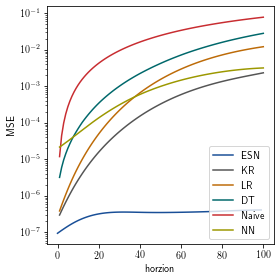

In [55]:
plt.figure(figsize=(4,4))
plt.plot(esn_err,label='ESN',color=colors[0])
for i,model in enumerate(models):
    plt.plot(list(range(1,101)), errs[i], label=model_names[i+1], color=colors[i+1])


plt.legend(loc='lower right')
plt.yscale('log')
plt.ylabel('MSE')
plt.xlabel('horzion')
plt.tight_layout()
plt.savefig(path+'/compare_multistep.pdf')